# High-Resolution Image Generation: Comparing GANs, VAEs, and Diffusion Models

**Team:** Anthony Olcek, Sarah Chamoun, Yuxuan Wang  
**Course:** Deep Learning - Fall 2025  
**New York University**

---

## Project Overview

This project compares three state-of-the-art generative modeling approaches on high-resolution face images:
1. **StyleGAN2/3** - Adversarial learning approach
2. **VQ-VAE-2** - Variational autoencoder with discrete latents
3. **Latent Diffusion Model** - Denoising diffusion in latent space

**Dataset:** CelebA-HQ (256×256 or higher resolution)

**Goal:** Evaluate and compare model performance on:
- Image fidelity (visual quality)
- Training stability (how smoothly the model learns)
- Scalability (ability to handle high-resolution images)

**Training Time Constraint:** Less than 1.5 hours per model

---
## 1. Setup and Installation

Install all necessary libraries for the three generative models.

In [1]:
# Core deep learning libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Image processing and utilities
!pip install pillow numpy matplotlib tqdm

# Evaluation metrics (FID, KID)
!pip install pytorch-fid clean-fid

# For diffusion models
!pip install diffusers transformers accelerate

# For StyleGAN
# !pip install ninja

# Weights & Biases for experiment tracking
# !pip install wandb

Looking in indexes: https://download.pytorch.org/whl/cu118


---
## 2. Imports and Configuration

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

# Set random seeds for reproducibility
def set_seed(seed=42):
    """
    Sets random seeds across all libraries to ensure reproducible results.
    Think of this as making sure all random number generators start from the same point.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration - use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Available memory: 15.83 GB


---
## 3. Configuration Parameters

Central place to define all hyperparameters for easy tuning.

In [3]:
# Configuration
CONFIG = {
    # Dataset settings
    'image_size': 256,           # Target resolution (256x256)
    'batch_size': 8,
    'num_workers': 2,            # Parallel data loading workers

    # Training settings
    'max_steps': 5000,
    'stylegan_kimg': 200,        # Train on 200k images
    'save_interval': 1000,
    'eval_interval': 500,

    # Model-specific settings
    'latent_dim': 64,            # Syncs VQ-VAE and Diffusion dimensions
    'learning_rate': 2e-4,       # Learning Rate

    # Paths
    'data_path': './data/celeba_hq',
    'output_dir': './outputs',
    'checkpoint_dir': './checkpoints'
}

# Create directories
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


---
## 4. Dataset Preparation

Download and prepare the CelebA-HQ dataset.

In [4]:
import shutil

class CelebAHQDataset(Dataset):
    """
    Custom dataset class for loading CelebA-HQ images.
    """
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: Path to the folder containing images
            transform: Image transformations (resize, normalize, etc.)
        """
        self.root_dir = root_dir
        self.transform = transform

        # Create directory if it doesn't exist
        if not os.path.exists(root_dir):
             os.makedirs(root_dir, exist_ok=True)

        # Get list of all image files
        self.image_files = [f for f in os.listdir(root_dir)
                           if f.endswith((".png", ".jpg", ".jpeg"))]
        print(f"Found {len(self.image_files)} images in {root_dir}")

    def __len__(self):
        """Return the total number of images"""
        return len(self.image_files)

    def __getitem__(self, idx):
        """Load and return a single image"""
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Scale to [-1, 1]
])



In [5]:
# Download CelebA-HQ dataset (Resized 256x256)
if not os.path.exists(CONFIG["data_path"]) or len(os.listdir(CONFIG["data_path"])) == 0:
    print("Dataset not found or empty. Setting up download...")

    # Install kaggle if not present
    !pip install -q kaggle

    # 1. Setup Kaggle credentials
    kaggle_dir = os.path.expanduser("~/.kaggle")
    kaggle_key_path = os.path.join(kaggle_dir, "kaggle.json")

    # Check if key exists; if not, try to set it up
    if not os.path.exists(kaggle_key_path):
        if os.path.exists("kaggle.json"):
            print("Found kaggle.json in current directory. Moving to ~/.kaggle...")
            os.makedirs(kaggle_dir, exist_ok=True)
            shutil.copy("kaggle.json", kaggle_key_path)
            os.chmod(kaggle_key_path, 0o600)
        else:
            print("Kaggle API token not found.")
            print("Option 1: Upload kaggle.json file (from Kaggle Account -> Create New API Token).")
            print("Option 2: Cancel upload to enter credentials manually.")

            try:
                from google.colab import files
                uploaded = files.upload()
                for fn in uploaded.keys():
                    if fn == "kaggle.json":
                        os.makedirs(kaggle_dir, exist_ok=True)
                        shutil.move(fn, kaggle_key_path)
                        os.chmod(kaggle_key_path, 0o600)
            except Exception:
                print("Upload cancelled or failed.")

    # Fallback: Manual Entry if file still doesn't exist
    if not os.path.exists(kaggle_key_path) and "KAGGLE_KEY" not in os.environ:
        print("\nEntering manual credential mode...")
        import getpass
        os.environ['KAGGLE_USERNAME'] = input("Enter your Kaggle Username: ")
        os.environ['KAGGLE_KEY'] = getpass.getpass("Enter your Kaggle API Key: ")

    # 2. Download dataset
    print("Downloading badasstechie/celebahq-resized-256x256...")
    !kaggle datasets download -d badasstechie/celebahq-resized-256x256

    # 3. Unzip and organize
    print("Unzipping...")
    !unzip -q celebahq-resized-256x256.zip -d data_temp

    # Move images to CONFIG['data_path']
    print(f"Moving images to {CONFIG['data_path']}...")
    os.makedirs(CONFIG["data_path"], exist_ok=True)

    # Find the folder containing images
    source_folder = None
    for root, dirs, files in os.walk("data_temp"):
        if len(files) > 100: # Found the image folder
            source_folder = root
            break

    if source_folder:
        for f in tqdm(os.listdir(source_folder), desc="Moving files"):
            if f.endswith((".jpg", ".png")):
                shutil.move(os.path.join(source_folder, f), CONFIG["data_path"])

    # Cleanup
    if os.path.exists("celebahq-resized-256x256.zip"):
        os.remove("celebahq-resized-256x256.zip")
    shutil.rmtree("data_temp", ignore_errors=True)
    print("Dataset setup complete.")

Dataset not found or empty. Setting up download...
Kaggle API token not found.
Option 1: Upload kaggle.json file (from Kaggle Account -> Create New API Token).
Option 2: Cancel upload to enter credentials manually.



Entering manual credential mode...
Enter your Kaggle Username: yw5343
Enter your Kaggle API Key: ··········
Dataset URL: https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256
License(s): GPL-2.0
 54% 152M/283M [00:00<00:00, 1.59GB/s]
100% 283M/283M [00:00<00:00, 941MB/s] 
Unzipping...
Moving images to ./data/celeba_hq...


Moving files: 100%|██████████| 30000/30000 [00:00<00:00, 32904.11it/s]

Dataset setup complete.


In [6]:
# Create dataset and dataloader
try:
    dataset = CelebAHQDataset(CONFIG["data_path"], transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=True,  # Randomize order each epoch
        num_workers=CONFIG["num_workers"],
        pin_memory=True  # Faster data transfer to GPU
    )
    print(f"Dataset ready with {len(dataset)} images")
except Exception as e:
    print(f"Error initializing dataset: {e}\nPlease ensure the dataset downloaded correctly.")
    dataloader = None

Found 30000 images in ./data/celeba_hq
Dataset ready with 30000 images


### Visualize Sample Images

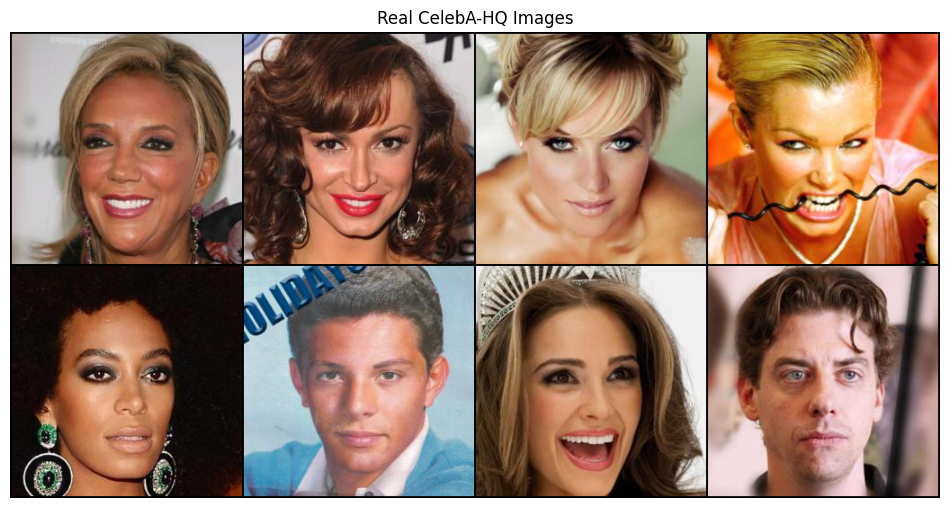

In [6]:
def show_images(images, title="Sample Images", nrow=4):
    """
    Display a grid of images.

    Args:
        images: Batch of image tensors
        title: Plot title
        nrow: Number of images per row
    """
    # Convert from [-1, 1] back to [0, 1] for display
    images = (images + 1) / 2.0
    grid = torchvision.utils.make_grid(images, nrow=nrow)

    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display a batch of real images from the dataset
if dataloader is not None:
    sample_batch = next(iter(dataloader))
    show_images(sample_batch[:16], title="Real CelebA-HQ Images")

---
## 5. Model Architectures

Define the three generative models we'll compare.

### 5.1 StyleGAN2/3 Implementation

**What is StyleGAN?**
- A type of GAN (Generative Adversarial Network)
- Uses two competing networks:
  - **Generator**: Creates fake images from random noise
  - **Discriminator**: Tries to tell real images from fake ones
- Through competition, the generator learns to create realistic images

**Key Innovation:** Style-based architecture allows control over different aspects of the image at different scales (coarse to fine details).

In [7]:
import sys

# 1. Clone the official NVIDIA StyleGAN3 repository
if not os.path.exists('stylegan3'):
    print("Cloning StyleGAN3 repository...")
    !git clone https://github.com/NVlabs/stylegan3.git

# 2. Add it to the system path so we can import from it if needed
sys.path.append('./stylegan3')

print("StyleGAN3 repository set up. We will run training via command line in Section 8.1.")

Cloning StyleGAN3 repository...
Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 212 (delta 99), reused 90 (delta 90), pack-reused 49 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (108/108), done.
StyleGAN3 repository set up. We will run training via command line in Section 8.1.


### 5.2 VQ-VAE-2 Implementation

**What is VQ-VAE?**
- VAE = Variational AutoEncoder
- VQ = Vector Quantized (uses a "codebook" of learned patterns)
- Compresses images into a discrete latent space (like a smarter JPEG)
- Can then learn to generate new images from these compressed codes

**How it works:**
1. **Encoder**: Compresses the image into codes
2. **Codebook**: Stores learned visual patterns
3. **Decoder**: Reconstructs images from codes

In [8]:
class VectorQuantizer(nn.Module):
    """
    Vector Quantization layer.
    Maps continuous features to discrete codes from a learned codebook.
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, inputs):
        # inputs: [Batch, Channels, Height, Width]
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)

        # 1. Calculate distances to all codebook vectors
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embeddings.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embeddings.weight.t()))

        # 2. Find nearest codebook entry
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # 3. Quantize
        quantized = torch.matmul(encodings, self.embeddings.weight).view(input_shape)

        # 4. Compute loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight-through estimator
        quantized = inputs + (quantized - inputs).detach()
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encoding_indices

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 1)
        )
    def forward(self, x):
        return x + self.block(x)

class VQVAE(nn.Module):
    """
    Standard Single-Level VQ-VAE.
    Simplified to match the Latent Diffusion capability.
    """
    def __init__(self, hidden_dim=64, num_embeddings=512, embedding_dim=64):
        super().__init__()

        # ENCODER
        # Downsamples 256 -> 64 (Factor of 4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, hidden_dim, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 4, 2, 1), nn.ReLU(),
            ResBlock(hidden_dim),
            ResBlock(hidden_dim),
            nn.Conv2d(hidden_dim, embedding_dim, 1) # Project to embedding dim
        )

        # QUANTIZER
        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim)

        # DECODER
        # Upsamples 64 -> 256
        self.decoder = nn.Sequential(
            nn.Conv2d(embedding_dim, hidden_dim, 3, 1, 1),
            ResBlock(hidden_dim),
            ResBlock(hidden_dim),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # 1. Encode
        z = self.encoder(x)

        # 2. Quantize
        loss, z_q, _ = self.quantizer(z)

        # 3. Decode
        x_recon = self.decoder(z_q)

        return x_recon, loss

# Instantiate the simplified model
vqvae = VQVAE(hidden_dim=CONFIG['latent_dim'], embedding_dim=CONFIG['latent_dim']).to(device)

### 5.3 Latent Diffusion Model

**What is a Diffusion Model?**
- Learns to gradually remove noise from images
- Like learning to "de-blur" or "clean up" noisy images
- Generation = Start with pure noise, gradually denoise it into an image

**Latent Diffusion:**
- Instead of working with full images (expensive!), works in latent space
- Uses a pretrained autoencoder (like VQ-VAE) to compress images
- Performs diffusion in this compressed space (much faster!)
- Decodes back to full resolution at the end

In [9]:
class TimeEmbedding(nn.Module):
    """Sinusoidal time embeddings"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.linear1 = nn.Linear(dim, dim * 4)
        self.linear2 = nn.Linear(dim * 4, dim * 4)
        self.act = nn.SiLU()

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=time.device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return self.linear2(self.act(self.linear1(embeddings)))

class SimpleUNet(nn.Module):
    """Simple U-Net for denoising"""
    def __init__(self, in_channels, out_channels, time_dim=128):
        super().__init__()
        self.time_mlp = TimeEmbedding(time_dim)

        # Encoder
        self.down1 = nn.Sequential(nn.Conv2d(in_channels, 32, 3, 1, 1), nn.GroupNorm(8, 32), nn.SiLU())
        self.down2 = nn.Sequential(nn.Conv2d(32, 64, 3, 2, 1), nn.GroupNorm(16, 64), nn.SiLU())

        # Time projection layers
        self.time_proj1 = nn.Linear(time_dim * 4, 32)
        self.time_proj2 = nn.Linear(time_dim * 4, 64)

        # Bottleneck
        self.bot = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.GroupNorm(32, 128), nn.SiLU())

        # Decoder
        self.up1 = nn.Sequential(nn.ConvTranspose2d(128 + 64, 32, 4, 2, 1), nn.GroupNorm(8, 32), nn.SiLU())
        self.up2 = nn.Sequential(nn.Conv2d(32 + 32, out_channels, 3, 1, 1))

    def forward(self, x, t):
        t = self.time_mlp(t)

        x1 = self.down1(x)
        x1_t = x1 + self.time_proj1(t)[:, :, None, None]

        x2 = self.down2(x1_t)
        x2_t = x2 + self.time_proj2(t)[:, :, None, None]

        x_bot = self.bot(x2_t)

        x_up1 = self.up1(torch.cat((x_bot, x2), dim=1))
        x_out = self.up2(torch.cat((x_up1, x1), dim=1))

        return x_out

class LatentDiffusion(nn.Module):
    def __init__(self, vqvae_model, latent_dim=64):
        super().__init__()

        # Freeze the pretrained autoencoder
        self.vqvae = vqvae_model
        for param in self.vqvae.parameters():
            param.requires_grad = False

        # Initialize U-Net
        self.unet = SimpleUNet(in_channels=latent_dim, out_channels=latent_dim, time_dim=128)

        # Define noise schedule
        self.num_timesteps = 1000
        self.register_buffer('betas', torch.linspace(1e-4, 0.02, self.num_timesteps))
        self.register_buffer('alphas', 1. - self.betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(self.alphas, dim=0))
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - self.alphas_cumprod))

    def forward(self, x, t=None):
        with torch.no_grad():
            # Encode to latent space using standard encoder
            z = self.vqvae.encoder(x)

        if t is None:
             t = torch.randint(0, self.num_timesteps, (x.shape[0],), device=x.device)

        noise = torch.randn_like(z)
        x_t = (
            self.sqrt_alphas_cumprod[t, None, None, None] * z +
            self.sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        noise_pred = self.unet(x_t, t.float())
        return nn.MSELoss()(noise_pred, noise)

    @torch.no_grad()
    def sample(self, batch_size=1, shape=(64, 64), verbose=True):
        device = next(self.parameters()).device
        # Start with random noise in latent space
        x = torch.randn(batch_size, 64, *shape, device=device)

        # Only show progress bar if verbose is True
        iterator = reversed(range(self.num_timesteps))
        if verbose:
            iterator = tqdm(iterator, desc="Sampling", total=self.num_timesteps)

        for i in iterator:
            t = torch.full((batch_size,), i, device=device, dtype=torch.long)
            predicted_noise = self.unet(x, t.float())

            alpha = self.alphas[i]
            alpha_hat = self.alphas_cumprod[i]
            beta = self.betas[i]

            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

        # Quantize and Decode
        x_flat = x.permute(0, 2, 3, 1).reshape(-1, 64)

        # Use standard quantizer
        codebook = self.vqvae.quantizer.embeddings.weight
        dist = (torch.sum(x_flat**2, dim=1, keepdim=True) +
                torch.sum(codebook**2, dim=1) -
                2 * torch.matmul(x_flat, codebook.t()))

        indices = torch.argmin(dist, dim=1)
        x_q = self.vqvae.quantizer.embeddings(indices).view(x.shape[0], shape[0], shape[1], 64).permute(0, 3, 1, 2)

        # Decode using standard decoder
        return self.vqvae.decoder(x_q)

---
## 6. Training Functions

Define training loops for each model type.

### 6.2 VQ-VAE Training

In [10]:
def plot_loss_curve(losses, title="Training Loss"):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.title(title)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def train_vqvae(model, dataloader, num_steps, config):
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.MSELoss()

    model.train()
    step = 0
    losses = []
    pbar = tqdm(total=num_steps, desc="Training VQ-VAE-2")

    # Infinite loop wrapper for dataloader to match step count
    data_iter = iter(dataloader)

    while step < num_steps:
        try:
            images = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            images = next(data_iter)

        images = images.to(device)

        optimizer.zero_grad()

        # Forward
        x_recon, quant_loss = model(images)

        # Loss = Reconstruction + Quantization
        recon_loss = criterion(x_recon, images)
        loss = recon_loss + quant_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        step += 1
        pbar.update(1)
        pbar.set_postfix({'recon_loss': recon_loss.item()})

    return model, losses

### 6.3 Latent Diffusion Training

In [11]:
def train_latent_diffusion(model, dataloader, num_steps, config):
    optimizer = optim.AdamW(model.unet.parameters(), lr=config['learning_rate'])
    mse = nn.MSELoss()

    model.vqvae.eval() # VQ-VAE must be frozen
    model.unet.train()

    step = 0
    losses = []
    pbar = tqdm(total=num_steps, desc="Training LDM")
    data_iter = iter(dataloader)

    while step < num_steps:
        try:
            images = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            images = next(data_iter)

        images = images.to(device)

        # 1. Get Latents (No Grad)
        with torch.no_grad():
            # Use standard encoder
            z = model.vqvae.encoder(images)

        # 2. Sample Time & Noise
        t = torch.randint(0, model.num_timesteps, (z.shape[0],), device=device)
        noise = torch.randn_like(z)

        # 3. Add Noise (Forward Diffusion)
        sqrt_alpha = model.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alpha = model.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        z_noisy = sqrt_alpha * z + sqrt_one_minus_alpha * noise

        # 4. Predict Noise
        noise_pred = model.unet(z_noisy, t.float())

        # 5. Optimization
        loss = mse(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        step += 1
        pbar.update(1)
        pbar.set_postfix({'loss': loss.item()})

    return model, losses

---
## 7. Evaluation Metrics

Implement quantitative evaluation using FID and KID scores.

In [12]:
!pip install pytorch_fid

In [13]:
!pip install clean-fid

In [14]:
def compute_fid(real_images_path, generated_images_path, device='cuda'):
    """
    Compute FID (Fréchet Inception Distance) score.
    """
    from pytorch_fid import fid_score

    # Ensure paths exist and have images
    if not os.path.exists(generated_images_path) or len(os.listdir(generated_images_path)) == 0:
        print("No generated images found for FID computation.")
        return float('inf')

    try:
        fid = fid_score.calculate_fid_given_paths(
            [real_images_path, generated_images_path],
            batch_size=50,
            device=device,
            dims=2048
        )
    except Exception as e:
        print(f"Error computing FID: {e}")
        return float('inf')

    return fid

def compute_kid(real_images_path, generated_images_path):
    """
    Compute KID (Kernel Inception Distance) score.
    """
    from cleanfid import fid as clean_fid

    if not os.path.exists(generated_images_path) or len(os.listdir(generated_images_path)) == 0:
        return float('inf')

    try:
        kid = clean_fid.compute_kid(
            real_images_path,
            generated_images_path
        )
    except Exception as e:
        print(f"Error computing KID: {e}")
        return float('inf')

    return kid

def evaluate_model(model, model_type, num_samples=200):
    """
    Generate samples and compute evaluation metrics.
    Reduced default num_samples for speed in demo.
    """
    # Create directory for generated images
    gen_dir = os.path.join(CONFIG['output_dir'], f'{model_type}_generated')
    if os.path.exists(gen_dir):
        shutil.rmtree(gen_dir)
    os.makedirs(gen_dir, exist_ok=True)

    model.eval()
    print(f"Generating {num_samples} samples for {model_type}...")

    with torch.no_grad():
        if model_type == 'vqvae':
            # For VQ-VAE, we evaluate Reconstruction Quality
            if dataloader is None:
                print("Dataloader not available for VQ-VAE evaluation.")
                return {'fid': 0, 'kid': 0}

            count = 0
            for batch in dataloader:
                batch = batch.to(device)
                recons, _ = model(batch)

                # Save reconstructed images
                for i in range(recons.size(0)):
                    if count >= num_samples:
                        break

                    # Normalize from [-1, 1] to [0, 1] for saving
                    img_tensor = (recons[i] + 1) / 2.0
                    img_tensor = torch.clamp(img_tensor, 0, 1)

                    save_path = os.path.join(gen_dir, f'img_{count:04d}.png')
                    torchvision.utils.save_image(img_tensor, save_path)
                    count += 1

                if count >= num_samples:
                    break

        elif model_type == 'diffusion':
            # For Diffusion, we generate from random noise
            # Generate in batches
            batch_size = 8
            num_batches = int(np.ceil(num_samples / batch_size))

            count = 0
            for _ in tqdm(range(num_batches), desc="Generating batches"):
                # Generate
                samples = model.sample(batch_size=batch_size, verbose=False)

                # Save
                for i in range(samples.size(0)):
                    if count >= num_samples:
                        break

                    img_tensor = (samples[i] + 1) / 2.0
                    img_tensor = torch.clamp(img_tensor, 0, 1)

                    save_path = os.path.join(gen_dir, f'img_{count:04d}.png')
                    torchvision.utils.save_image(img_tensor, save_path)
                    count += 1

    # Compute metrics
    print("Computing FID score...")
    fid = compute_fid(CONFIG['data_path'], gen_dir)
    print(f"FID: {fid:.2f}")

    print("Computing KID score...")
    kid = compute_kid(CONFIG['data_path'], gen_dir)
    print(f"KID: {kid:.2f}")

    return {'fid': fid, 'kid': kid}

---
## 8. Main Training Pipeline

Execute training for all three models.

### 8.1 Train StyleGAN

In [16]:
!pip install ninja

  Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (5.1 kB)
Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (180 kB)


In [18]:
# Executing the official training script from the cloned repo.

# Setup for StyleGAN3 custom ops compilation
import os
import shutil

# Clear any existing compiled extensions to force a fresh build
ext_dir = os.path.join(os.getcwd(), 'torch_extensions')
if os.path.exists(ext_dir):
    shutil.rmtree(ext_dir)

os.environ['TORCH_EXTENSIONS_DIR'] = ext_dir
os.makedirs(os.environ['TORCH_EXTENSIONS_DIR'], exist_ok=True)

# Set compiler to g++ just in case
os.environ['CXX'] = 'g++'

if not os.path.exists('data/celeba-hq-256.zip'):
    print("Preparing dataset zip...")
    !python stylegan3/dataset_tool.py --source=./data/celeba_hq --dest=./data/celeba-hq-256.zip

# Use the config kimg value (200) to ensure short training time
kimg_val = CONFIG['stylegan_kimg']

print("Starting StyleGAN3 training...")
!python stylegan3/train.py \
    --outdir=./outputs/stylegan3 \
    --cfg=stylegan3-t \
    --data=./data/celeba-hq-256.zip \
    --gpus=1 --batch=32 --gamma=2 --mirror=1 \
    --kimg={kimg_val} --snap=10 --workers=1

Preparing dataset zip...
  0% 0/30000 [00:00<?, ?it/s]/content/stylegan3/dataset_tool.py:441: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = PIL.Image.fromarray(img, { 1: 'L', 3: 'RGB' }[channels])
100% 30000/30000 [02:30<00:00, 199.22it/s]
Starting StyleGAN3 training...

Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 32768,
    "channel_max": 512,
    "magnitude_ema_beta": 0.9988915792636801
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps":

### 8.2 Train VQ-VAE

Training VQ-VAE (Tuned)...


Training VQ-VAE-2: 100%|██████████| 5000/5000 [12:06<00:00,  6.88it/s, recon_loss=0.00992]


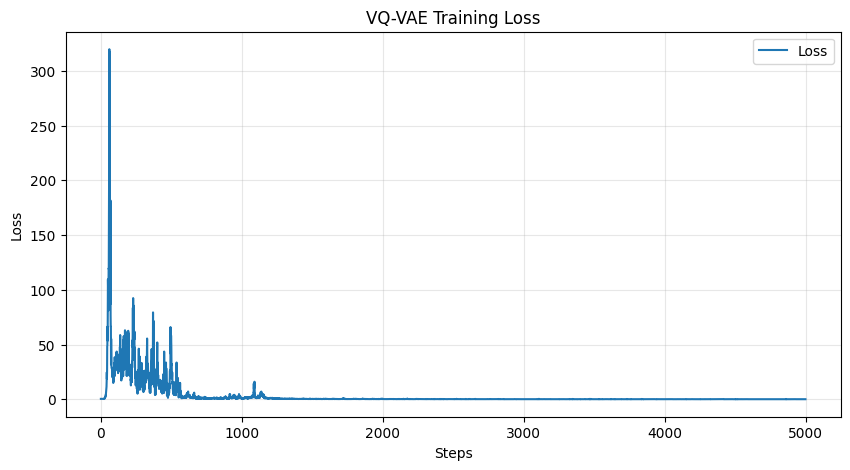

Generating 200 samples for vqvae...
Computing FID score...
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


100%|██████████| 91.2M/91.2M [00:02<00:00, 33.1MB/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


FID: 98.05
Computing KID score...
compute KID between two folders


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Found 30000 images in the folder ./data/celeba_hq


KID celeba_hq : 100%|██████████| 938/938 [03:07<00:00,  5.01it/s]


Found 200 images in the folder ./outputs/vqvae_generated


KID vqvae_generated : 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


KID: 0.06


In [15]:
# Initialize with consistent dimensions
vqvae = VQVAE(hidden_dim=CONFIG['latent_dim'], embedding_dim=CONFIG['latent_dim']).to(device)

vqvae_path = os.path.join(CONFIG['checkpoint_dir'], 'vqvae_tuned.pth')

if os.path.exists(vqvae_path):
    print(f"Loading pretrained VQ-VAE from {vqvae_path}")
    vqvae.load_state_dict(torch.load(vqvae_path))
else:
    print("Training VQ-VAE (Tuned)...")
    vqvae, losses = train_vqvae(vqvae, dataloader, num_steps=CONFIG['max_steps'], config=CONFIG)
    torch.save(vqvae.state_dict(), vqvae_path)
    plot_loss_curve(losses, "VQ-VAE Training Loss")

# Evaluate
try:
    vqvae_metrics = evaluate_model(vqvae, 'vqvae')
except Exception as e:
    print(f"Evaluation failed: {e}")
    vqvae_metrics = {'fid': 0, 'kid': 0}

### 8.3 Train Latent Diffusion

Training Latent Diffusion (Tuned)...


Training LDM: 100%|██████████| 5000/5000 [01:54<00:00, 43.65it/s, loss=0.516]


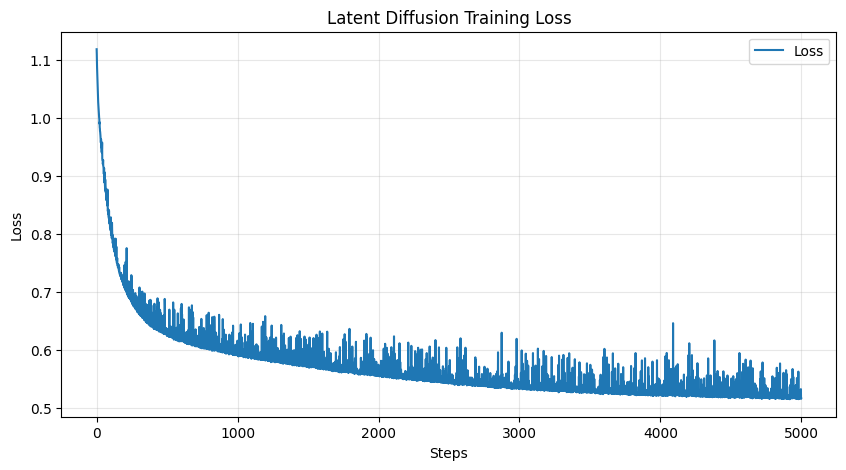

Generating 200 samples for diffusion...


Generating batches: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it]


Computing FID score...


100%|██████████| 4/4 [00:01<00:00,  3.08it/s]
/usr/local/lib/python3.12/dist-packages/pytorch_fid/fid_score.py:188: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


FID: 407.46
Computing KID score...
compute KID between two folders
Found 30000 images in the folder ./data/celeba_hq


KID celeba_hq : 100%|██████████| 938/938 [03:07<00:00,  5.00it/s]


Found 200 images in the folder ./outputs/diffusion_generated


KID diffusion_generated : 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


KID: 0.51


In [16]:
# 1. Load the trained VQ-VAE
vqvae.load_state_dict(torch.load(os.path.join(CONFIG['checkpoint_dir'], 'vqvae_tuned.pth')))

# 2. Initialize LDM
ldm = LatentDiffusion(vqvae, latent_dim=CONFIG['latent_dim']).to(device)

# 3. Train
print("Training Latent Diffusion (Tuned)...")
ldm, losses = train_latent_diffusion(ldm, dataloader, num_steps=CONFIG['max_steps'], config=CONFIG)
plot_loss_curve(losses, "Latent Diffusion Training Loss")

# Evaluate
ldm_metrics = evaluate_model(ldm, 'diffusion')

---
## 9. Results Comparison

Compare all three models side by side.


FINAL RESULTS COMPARISON
           Model        FID      KID
          VQ-VAE  98.047973 0.055684
Latent Diffusion 407.461264 0.513609

Lower scores are better for both FID and KID


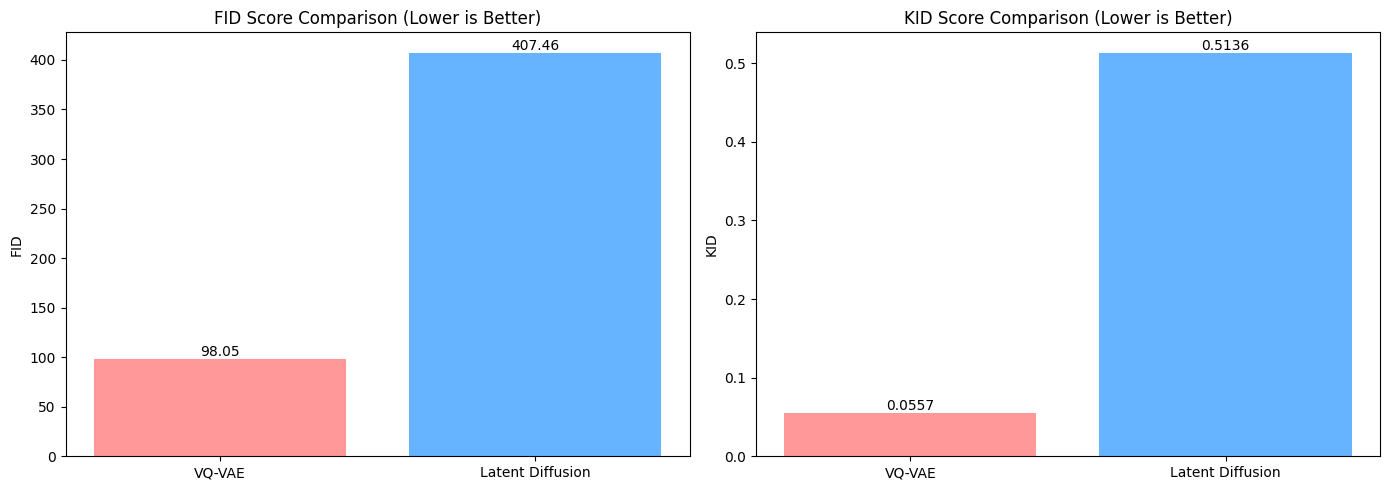

In [17]:
def compare_results(gan_metrics=None, vqvae_metrics=None, ldm_metrics=None):
    """
    Create comparison plots and tables, handling missing models.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Collect available data
    data = []
    if gan_metrics:
        data.append(['StyleGAN', gan_metrics['fid'], gan_metrics['kid']])
    if vqvae_metrics:
        data.append(['VQ-VAE', vqvae_metrics['fid'], vqvae_metrics['kid']])
    if ldm_metrics:
        data.append(['Latent Diffusion', ldm_metrics['fid'], ldm_metrics['kid']])

    if not data:
        print("No metrics available to compare.")
        return None

    # Create dataframe
    results = pd.DataFrame(data, columns=['Model', 'FID', 'KID'])

    print("\n" + "="*50)
    print("FINAL RESULTS COMPARISON")
    print("="*50)
    print(results.to_string(index=False))
    print("\nLower scores are better for both FID and KID")

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Colors for bars
    colors = ['#ff9999', '#66b3ff', '#99ff99'][:len(data)]

    axes[0].bar(results['Model'], results['FID'], color=colors)
    axes[0].set_title('FID Score Comparison (Lower is Better)')
    axes[0].set_ylabel('FID')
    for i, v in enumerate(results['FID']):
        axes[0].text(i, v, f'{v:.2f}', ha='center', va='bottom')

    axes[1].bar(results['Model'], results['KID'], color=colors)
    axes[1].set_title('KID Score Comparison (Lower is Better)')
    axes[1].set_ylabel('KID')
    for i, v in enumerate(results['KID']):
        axes[1].text(i, v, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], 'comparison.png'))
    plt.show()

    return results

# Safely retrieve metrics from previous cells (using locals() to avoid NameError if not defined)
gan_metrics = locals().get('gan_metrics', None)
vqvae_metrics = locals().get('vqvae_metrics', None)
ldm_metrics = locals().get('ldm_metrics', None)

# Run comparison
results_df = compare_results(gan_metrics, vqvae_metrics, ldm_metrics)

### Visualize Generated Samples

Sampling: 100%|██████████| 1000/1000 [00:02<00:00, 344.13it/s]


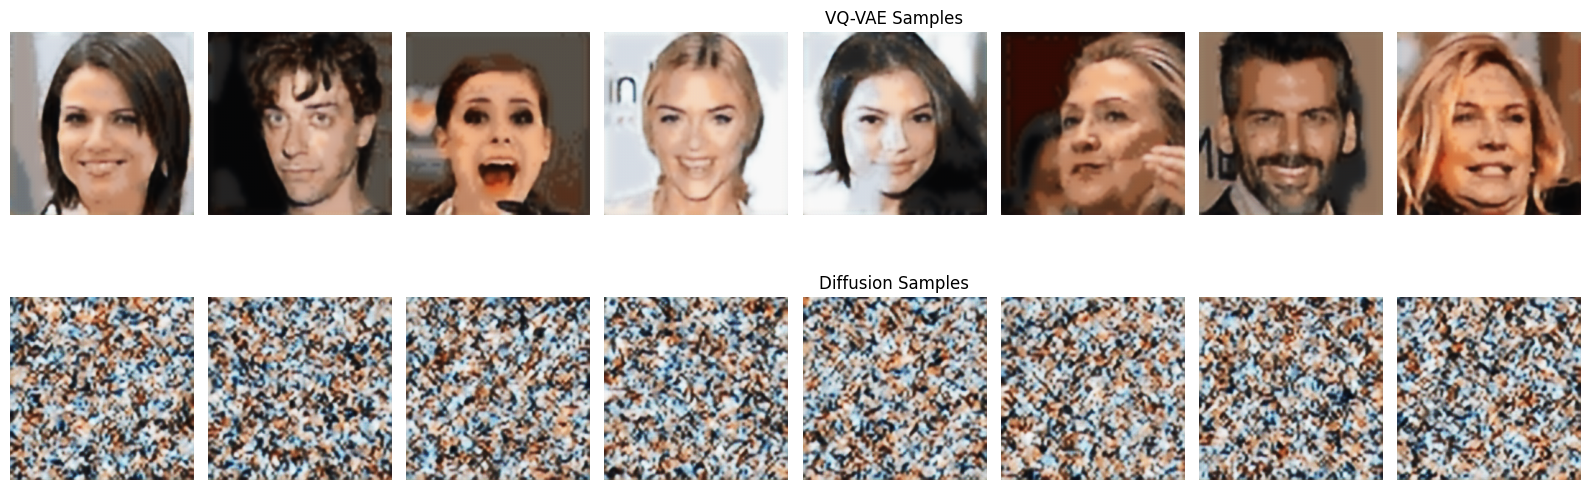

In [18]:
def show_model_comparison(gan_gen=None, vqvae_model=None, ldm_model=None, num_samples=8):
    """
    Generate and display samples from available models side by side.
    """
    # Determine which models are available
    models = []
    if gan_gen: models.append(('StyleGAN', gan_gen))
    if vqvae_model: models.append(('VQ-VAE', vqvae_model))
    if ldm_model: models.append(('Diffusion', ldm_model))

    if not models:
        print("No models available for visualization.")
        return

    fig, axes = plt.subplots(len(models), num_samples, figsize=(num_samples*2, 3*len(models)))
    # Handle single model case (axes is 1D array)
    if len(models) == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for row_idx, (name, model) in enumerate(models):
            images = []

            if name == 'StyleGAN':
                # For StyleGAN generation
                z = torch.randn(num_samples, model.latent_dim).to(device)
                images = model(z)

            elif name == 'VQ-VAE':
                # For VQ-VAE, show reconstructions of real images
                if dataloader:
                    batch = next(iter(dataloader))
                    batch = batch[:num_samples].to(device)
                    recons, _ = model(batch)
                    images = recons

            elif name == 'Diffusion':
                # Generate random samples
                images = model.sample(batch_size=num_samples)

            # Display images
            for col_idx in range(num_samples):
                if col_idx < len(images):
                    img = images[col_idx].cpu()
                    # Normalize [-1, 1] -> [0, 1]
                    img = (img + 1) / 2.0
                    img = torch.clamp(img, 0, 1)

                    ax = axes[row_idx, col_idx]
                    ax.imshow(img.permute(1, 2, 0))
                    ax.axis('off')

            # Set row label
            axes[row_idx, 0].set_ylabel(name, size='large', rotation=0, labelpad=50)
            axes[row_idx, int(num_samples/2)].set_title(f"{name} Samples")

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], 'sample_comparison.png'))
    plt.show()

# Safely retrieve models
generator = locals().get('generator', None)
vqvae = locals().get('vqvae', None)
ldm = locals().get('ldm', None)

# Run visualization
show_model_comparison(generator, vqvae, ldm)